In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
purple = (0.459, 0.235, 0.745)
gray = (0.827, 0.827, 0.827)
black = (0.137, 0.122, 0.125)
red= (0.957, 0.153, 0.212)
blue= (0, 0.667, 0.906)


In [3]:
wego = pd.read_csv("../data/headway_data.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


### Cleaning and Adding Columns for questions


In [4]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

# create headway deviation percentable column
wego.loc[:, 'HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [5]:
# Create Bunching or Gapping Indicator
def is_hdwy_bunching(dev, pct):
    if (dev < 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_gapping(dev, pct):
    if (dev > 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_acceptable(pct):
    if pct <= 50:
        return int(1)
    else:
        return int(0)

In [6]:
#Creating Columns for HDWY
wego.loc[:, 'HDWY_BUNCHING'] = wego.apply(lambda r: 
                                          is_hdwy_bunching(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_ACCEPTABLE'] = wego.apply(lambda r: 
                                            is_hdwy_acceptable(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_GAPPING'] = wego.apply(lambda r: 
                                         is_hdwy_gapping(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)

In [7]:
wego.head(1)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,1,0,0.0,0,6.5,NaN,NaN,0,0,0


In [8]:
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

### Question 1 Was done by teammates

### Question 2 : How does direction of travel, route, or location affect the headway and on-time performance?

In [9]:
to_downtown = wego[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']

In [10]:
from_downtown = wego[wego['ROUTE_DIRECTION_NAME'] == 'FROM DOWNTOWN']

In [11]:
to_downtown['HDWY_DEV'].mean()

0.4477730454373861

In [12]:
from_downtown['HDWY_DEV'].mean()

0.579990048857078

### Slighly higher headway deviation going from downtown then towards

In [13]:
to_downtown['ADHERENCE'].mean()

-2.3218044230829493

In [14]:
from_downtown['ADHERENCE'].mean()

-3.960287122712012

### From downtown and to downtown are both 'on time' using the required criteria. BUT towards downtown is slightly faster

In [15]:
wego[wego['ROUTE_DIRECTION_NAME']=='FROM DOWNTOWN']['ADHERENCE'].apply(['min','max','mean','median'])

min      -948.533333
max        76.766666
mean       -3.960287
median     -2.516666
Name: ADHERENCE, dtype: float64

In [16]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].describe()

ADHERENCE                                                      \
               count      mean       std         min       25%       50%   
ROUTE_ABBR                                                                 
3            45488.0 -3.761491  5.415910 -133.250000 -5.350000 -2.566666   
7            17267.0 -3.346555  6.669753  -87.716666 -4.916666 -2.116666   
22           25188.0 -1.138107  6.391798 -675.000000 -2.950000 -0.933333   
23           39653.0 -1.760110  7.680491 -618.166666 -3.116666 -1.316666   
50           42629.0 -2.505022  6.159666 -489.316666 -3.883333 -1.800000   
52           49327.0 -3.971342  8.721732 -948.533333 -5.016666 -2.066666   
55           60359.0 -4.823302  7.535092 -375.233333 -6.583333 -2.883333   
56           58950.0 -2.703988  4.931009 -322.783333 -4.300000 -1.900000   

                                HDWY_DEV                                  \
                 75%        max    count      mean        std        min   
ROUTE_ABBR                                                                 
3          -0.766666  33.750000  36583.0  0.580907   6.203530 -64.000000   
7          -0.616666  88.383333  11578.0  0.336808   5.909983 -30.433334   
22          0.816666  24.733333  17007.0  0.955867  10.248444 -43.650000   
23          0.033333  33.633333  28478.0  1.053563   9.881327 -32.116667   
50         -0.300000  22.350000  34593.0  0.212376   4.760558 -33.250000   
52         -0.400000  30.200000  39887.0  0.974776   9.185015 -55.533334   
55         -0.850000  40.250000  49432.0  0.261038   6.364978 -29.933334   
56         -0.283333  39.916666  48335.0  0.149213   4.714435 -27.266667   

                                                      
                 25%       50%       75%         max  
ROUTE_ABBR                                            
3          -2.450000  0.116666  2.800000   76.866666  
7          -1.983334  0.033333  2.133333   50.250000  
22         -1.966667  0.050000  2.200000  508.700000  
23         -1.733334  0.066666  2.066666  565.433333  
50         -2.083334  0.033333  2.183333   54.283333  
52         -2.450000  0.083333  2.783333  472.366666  
55         -3.150000 -0.033334  2.983333  102.000000  
56         -2.333334  0.000000  2.383333  166.000000

In [17]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Route 22 has better over all Adherence while route 56 has a better headway deviation

In [18]:
wego.groupby('BLOCK_ABBR')[['ADHERENCE','HDWY_DEV']].mean().abs().sort_values('ADHERENCE', ascending = True)

,ADHERENCE,HDWY_DEV
BLOCK_ABBR,,
8604,0.281250,1.238889
2301,0.353140,0.263938
2210,0.442440,0.874254
2211,0.529404,0.778633
8401,0.603704,NaN
...,...,...
5218,7.901945,3.985199
5513,8.414195,0.912638
5590,9.226351,NaN


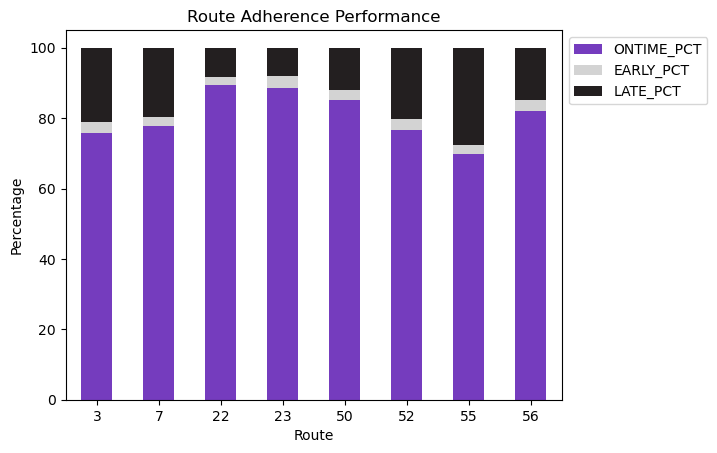

In [19]:
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True, color=[purple,gray,black])
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

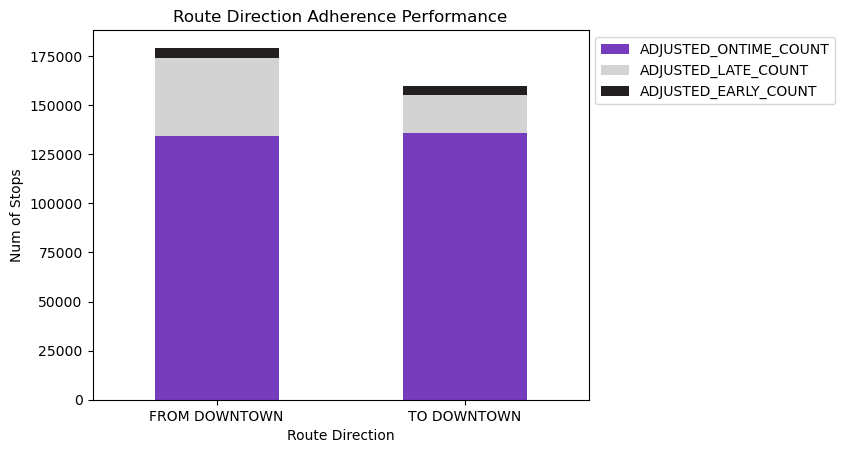

In [20]:
ax = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Route Direction Adherence Performance',
        xlabel = 'Route Direction',
       ylabel = 'Num of Stops')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

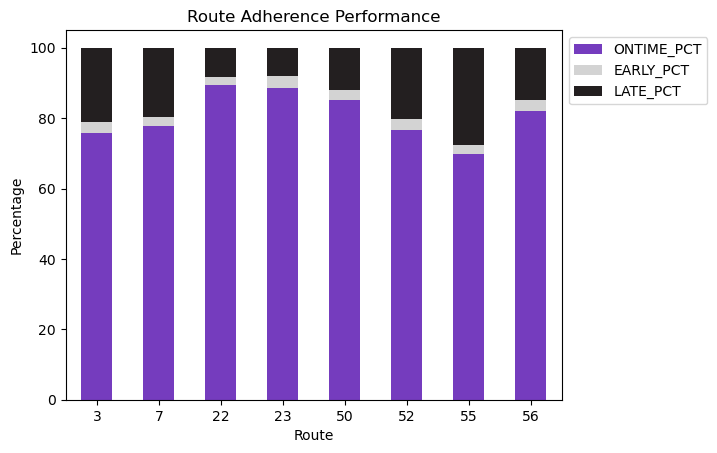

In [21]:
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('V:\pictures')

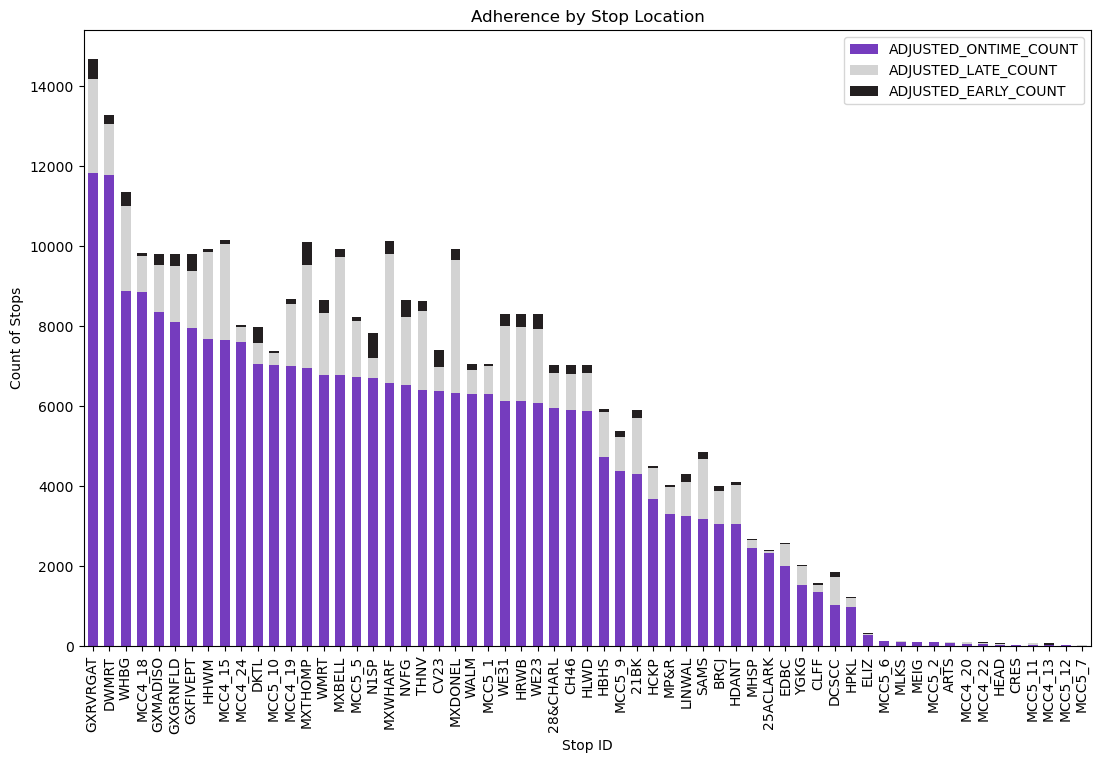

In [22]:
loc_adh_chart = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True, color=[purple,gray,black], width=0.6, figsize=(13,8))
loc_adh_chart.set(title='Adherence by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
loc_adh_chart.legend(bbox_to_anchor=(1, 1))
#plt.savefig('V:\pictures')

In [23]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending = True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,-37.570714,NaN
MCC4_20,-13.356229,NaN
MCC5_12,-9.785042,NaN
MCC5_7,-9.075463,NaN
DCSCC,-7.091481,12.054055
...,...,...
HEAD,1.013657,NaN
MCC5_2,1.252623,NaN
25ACLARK,1.458553,0.551163


## Question 3: How does time of day or day of week affect headway and on-time performance?

In [24]:
### Changed Date column to datetime
wego['DATE'] = pd.to_datetime(wego['DATE'])

In [25]:
wego['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday

In [26]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday

C:\Users\asus\AppData\Local\Temp\ipykernel_23788\2490818292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday


In [27]:
wego['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                         format='mixed').dt.hour)

In [28]:
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                         format='mixed').dt.hour)

C:\Users\asus\AppData\Local\Temp\ipykernel_23788\293309290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],


In [29]:
adherence_by_hour = clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean()
adherence_by_hour

,ADHERENCE,HDWY_DEV
HOUR,,
0,-4.478019,0.905051
1,-10.618182,4.021621
4,-0.785533,-0.771043
5,-0.966710,0.306431
6,-1.501108,0.347326
7,-2.691298,0.700018
8,-3.758128,0.413859
9,-2.611876,0.265547
10,-2.117932,0.314521


<Axes: xlabel='HOUR'>

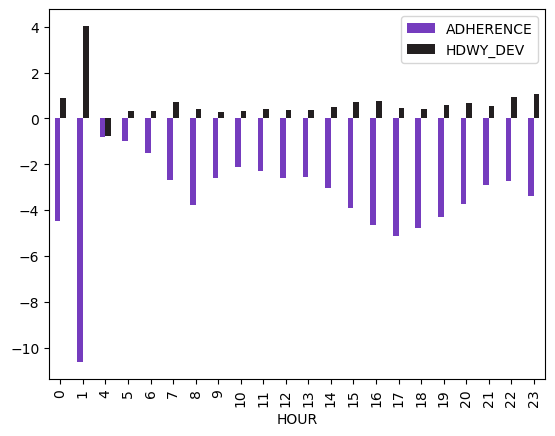

In [30]:
clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean().plot(kind='bar', color=[purple,black])
#plt.savefig('V:\hour_adh_hdwy')


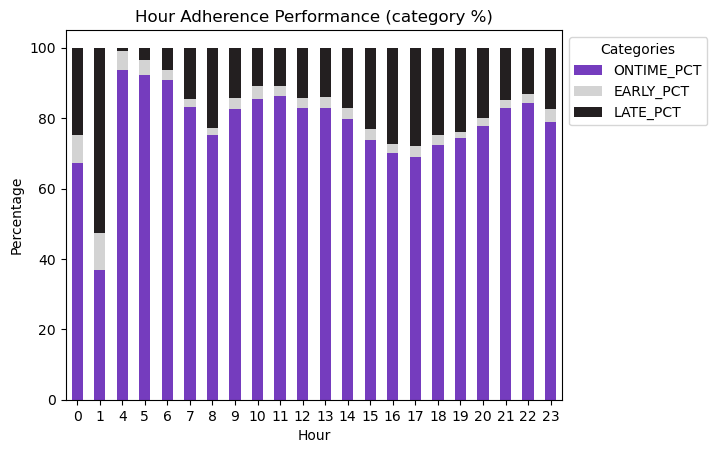

In [31]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
        [['ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_EARLY_COUNT']].sum())

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals.loc[:, 'ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals.loc[:, 'LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

ax = (hour_totals[['ONTIME_PCT','EARLY_PCT','LATE_PCT']]).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Hour Adherence Performance (category %)',
            xlabel = 'Hour',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.tick_params(axis='x', rotation=0)

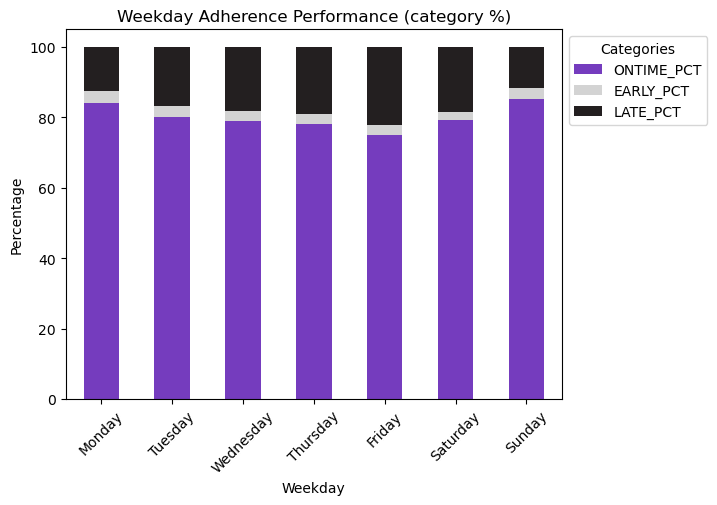

In [32]:
weekday_totals = (
    clean_dept_time.groupby('WEEKDAY')
        [['ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_EARLY_COUNT']].sum())

weekday_totals['TOTALS'] = weekday_totals.sum(axis=1)

weekday_totals.loc[:, 'ONTIME_PCT'] = weekday_totals['ADJUSTED_ONTIME_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'EARLY_PCT'] = weekday_totals['ADJUSTED_EARLY_COUNT'] / weekday_totals['TOTALS'] * 100
weekday_totals.loc[:, 'LATE_PCT'] = weekday_totals['ADJUSTED_LATE_COUNT'] / weekday_totals['TOTALS'] * 100

ax = (weekday_totals[['ONTIME_PCT','EARLY_PCT','LATE_PCT']]).plot(kind='bar', stacked=True,color=[purple,gray,black])
ax.set(title = 'Weekday Adherence Performance (category %)',
            xlabel = 'Weekday',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)
#plt.savefig('V:\Adherence')

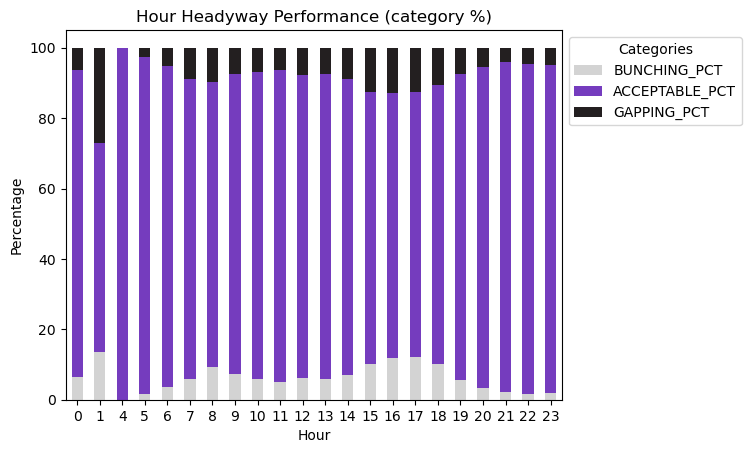

In [33]:
hour_hdwy_totals = (
    clean_dept_time.groupby('HOUR')
        [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
        .sum()
)

hour_hdwy_totals['TOTALS'] = hour_hdwy_totals.sum(axis=1)

hour_hdwy_totals.loc[:, 'BUNCHING_PCT'] = hour_hdwy_totals['HDWY_BUNCHING'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = hour_hdwy_totals['HDWY_ACCEPTABLE'] / hour_hdwy_totals['TOTALS'] * 100
hour_hdwy_totals.loc[:, 'GAPPING_PCT'] = hour_hdwy_totals['HDWY_GAPPING'] / hour_hdwy_totals['TOTALS'] * 100

ax = (hour_hdwy_totals[['BUNCHING_PCT','ACCEPTABLE_PCT','GAPPING_PCT']]).plot(kind='bar', stacked=True,color=[gray,purple,black])
ax.set(title = 'Hour Headyway Performance (category %)',
            xlabel = 'Hour',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.tick_params(axis='x', rotation=0)
#plt.savefig('V:\pictures')

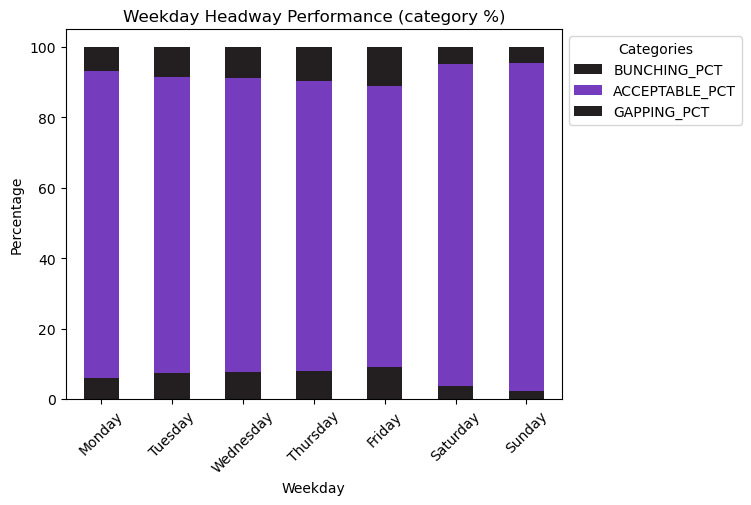

In [34]:
weekday_hdwy_totals = (
    clean_dept_time.groupby('WEEKDAY')
        [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
        .sum()
)

weekday_hdwy_totals['TOTALS'] = weekday_hdwy_totals.sum(axis=1)

weekday_hdwy_totals.loc[:, 'BUNCHING_PCT'] = weekday_hdwy_totals['HDWY_BUNCHING'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'ACCEPTABLE_PCT'] = weekday_hdwy_totals['HDWY_ACCEPTABLE'] / weekday_hdwy_totals['TOTALS'] * 100
weekday_hdwy_totals.loc[:, 'GAPPING_PCT'] = weekday_hdwy_totals['HDWY_GAPPING'] / weekday_hdwy_totals['TOTALS'] * 100

ax = (weekday_hdwy_totals[['BUNCHING_PCT','ACCEPTABLE_PCT','GAPPING_PCT']]).plot(kind='bar', stacked=True,color=[black, purple])
ax.set(title = 'Weekday Headway Performance (category %)',
            xlabel = 'Weekday',
            ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title ='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)
#plt.savefig('V:\pictures')

### The early time of day ie: 4am - 2pm have around the same adherence around -1 - -3 then spikes up to -4 and -5 until it starts dropping back down at 9pm. 1am is an outlire with an average of -10

### The headway deviation is all around the 0 mark except for a large outlire at 1am with a average headway of 4

In [35]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

C:\Users\asus\AppData\Local\Temp\ipykernel_23788\2176059727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday


In [36]:
adherence_by_day = clean_dept_time.groupby('WEEKDAY')[['ADHERENCE', 'HDWY_DEV']].mean()
adherence_by_day

,ADHERENCE,HDWY_DEV
WEEKDAY,,
0,-2.434586,0.289773
1,-2.952484,0.401450
2,-3.264622,0.368556
3,-3.455171,0.524049
4,-3.792110,0.644195
5,-3.400493,0.633628
6,-2.808781,1.016830


In [37]:
wego.groupby('HOUR')[['HDWY_DEV','SCHEDULED_HDWY']].mean()

,HDWY_DEV,SCHEDULED_HDWY
HOUR,,
0.0,0.905051,32.144821
1.0,4.021621,44.594595
4.0,-0.771043,23.632184
5.0,0.306431,20.891133
6.0,0.347326,16.538616
7.0,0.700018,14.938857
8.0,0.413859,15.338848
9.0,0.265547,16.344796
10.0,0.314521,16.090257


In [38]:
wego[['HDWY_DEV_PCT','HDWY_BUNCHING','HDWY_ACCEPTABLE','HDWY_GAPPING']]

,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING
0,NaN,0,0,0
1,NaN,0,0,0
2,NaN,0,0,0
3,NaN,0,0,0
4,NaN,0,0,0
...,...,...,...,...
350324,17.555553,0,1,0
350325,NaN,0,0,0
350326,6.222220,0,1,0
350327,58.333333,0,0,1


### Question 4: How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

In [39]:
adherence_op = wego.groupby('OPERATOR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending = False)
adherence_op = adherence_op.dropna(subset = 'HDWY_DEV')

In [40]:
hdwy_op = wego.groupby('OPERATOR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('HDWY_DEV', ascending = False)
hdwy_op = hdwy_op.dropna(subset = 'HDWY_DEV')

In [41]:
operator_totals = (
    wego.groupby('OPERATOR')
        [['ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT',
          'ADJUSTED_EARLY_COUNT','HDWY_BUNCHING',
          'HDWY_ACCEPTABLE','HDWY_GAPPING']]
          .sum()
)

operator_totals['ADH_TOTALS'] = (operator_totals[['ADJUSTED_ONTIME_COUNT',
                                             'ADJUSTED_LATE_COUNT',
                                             'ADJUSTED_EARLY_COUNT']].sum(axis=1))

operator_totals['HDWY_TOTALS'] = (operator_totals[['HDWY_BUNCHING',
                                             'HDWY_ACCEPTABLE',
                                             'HDWY_GAPPING']].sum(axis=1))

In [42]:
operator_totals.loc[:, 'BUNCHING_PCT'] = round(operator_totals['HDWY_BUNCHING'] / operator_totals['HDWY_TOTALS'] * 100,1)
operator_totals.loc[:, 'ACCEPTABLE_PCT'] = round(operator_totals['HDWY_ACCEPTABLE'] / operator_totals['HDWY_TOTALS'] * 100,1)
operator_totals.loc[:, 'GAPPING_PCT'] = round(operator_totals['HDWY_GAPPING'] / operator_totals['HDWY_TOTALS'] * 100,1)
operator_totals.loc[:, 'ONTIME_PCT'] = round(operator_totals['ADJUSTED_ONTIME_COUNT'] / operator_totals['ADH_TOTALS'] * 100,1)
operator_totals.loc[:, 'EARLY_PCT'] = round(operator_totals['ADJUSTED_EARLY_COUNT'] / operator_totals['ADH_TOTALS'] * 100,1)
operator_totals.loc[:, 'LATE_PCT'] = round(operator_totals['ADJUSTED_LATE_COUNT'] / operator_totals['ADH_TOTALS'] * 100,1)

In [43]:
operator_sum = operator_totals[['HDWY_TOTALS','ACCEPTABLE_PCT','ADH_TOTALS','ONTIME_PCT']]
operator_sum

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
0,0,NaN,1,100.0
56,2,100.0,3,100.0
235,9,77.8,12,50.0
244,20,65.0,25,80.0
301,30,53.3,37,51.4
...,...,...,...,...
3149,56,92.9,88,86.4
3156,230,95.7,290,75.5
3165,24,66.7,32,37.5


In [44]:
operator_adh_top = ( 
    operator_sum
            .loc[operator_totals['ADH_TOTALS'] >= 1000]
            .nlargest(20, columns=['ONTIME_PCT','ADH_TOTALS'])
)

operator_hdwy_top = ( 
    operator_sum
            .loc[operator_totals['HDWY_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_PCT','HDWY_TOTALS'])
)

In [45]:
top_operators = pd.merge(operator_adh_top,operator_hdwy_top[[]], how="inner", on='OPERATOR')
top_operators

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
1762,1553,91.4,2333,98.3
409,1715,96.6,2380,97.1
1566,1835,98.0,2200,97.0
1927,1960,95.4,2413,96.0
1040,1058,97.4,1770,95.8
1133,2177,93.6,2625,95.4
1617,1281,97.2,1806,95.3
2321,1180,93.7,1420,94.0
2088,1528,94.1,2021,92.8


In [46]:
operator_sum = operator_totals[['HDWY_TOTALS','ACCEPTABLE_PCT','ADH_TOTALS','ONTIME_PCT']]

In [47]:
operator_adh_bot = ( 
    operator_sum
            .loc[operator_totals['ADH_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ONTIME_PCT','ADH_TOTALS'])
)

operator_hdwy_bot = ( 
    operator_sum
            .loc[operator_totals['HDWY_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_PCT','HDWY_TOTALS'])
)

In [48]:
bot_operators = pd.merge(operator_adh_bot,operator_hdwy_bot[[]], how="inner", on='OPERATOR')
bot_operators

,HDWY_TOTALS,ACCEPTABLE_PCT,ADH_TOTALS,ONTIME_PCT
OPERATOR,,,,
3101,1055,73.0,1297,44.6
1800,1298,73.8,1625,48.6
2109,1707,68.8,2093,54.4
357,1204,75.6,1584,54.7
1352,1412,63.5,1693,56.3
1277,1075,74.8,1375,57.8
2356,1105,69.0,1408,58.2
2082,1460,70.8,1759,58.4
1359,1289,65.4,1548,59.6


In [49]:
top_bot_operators = pd.concat([top_operators,bot_operators])
top_bot_operators = top_bot_operators.sort_values('ONTIME_PCT', ascending = True)

In [50]:
top_bot_operators.loc[:, 'NEGATIVE_ACCEPTABLE'] = top_bot_operators['ACCEPTABLE_PCT'].apply(lambda pct: -pct)

In [51]:
# function to correct negative 
def get_label_value(num):
    if num >= 0:
        return str(num) + '%'
    else:
        return str(-num) +'%'

C:\Users\asus\AppData\Local\Temp\ipykernel_23788\1787542536.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])


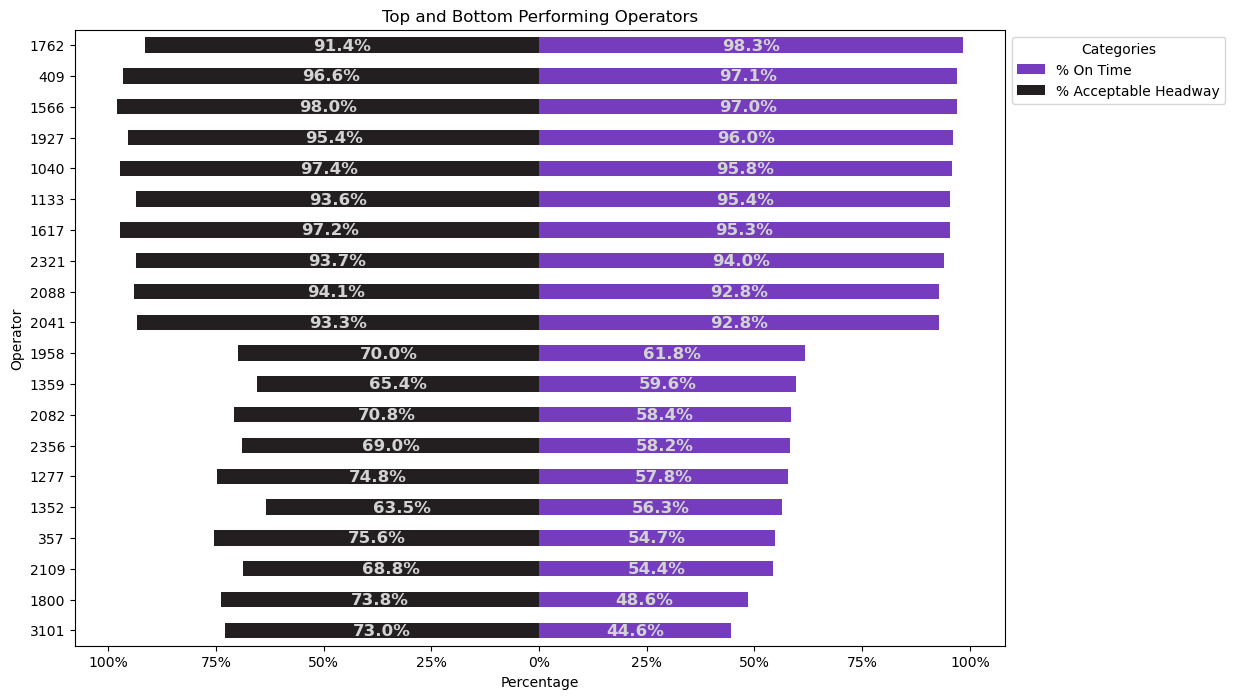

In [52]:
ax = top_bot_operators[['ONTIME_PCT', 'NEGATIVE_ACCEPTABLE']].plot(kind='barh',
                                                                      stacked=True,
                                                                      figsize=(12, 8),
                                                                     color= [purple,black])

ax.set(title = 'Top and Bottom Performing Operators',
        xlabel = 'Percentage',
       ylabel = 'Operator')

# set bar labels
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2, # horizontal alignment
      bar.get_height() + bar.get_y() - 0.41, # vertical alignment
      get_label_value(bar.get_width()), # value
      ha='center', # Center the labels
      color=gray,
      weight='bold',
      size=12
  )

ax.legend(bbox_to_anchor=(1, 1), title='Categories', labels = ['% On Time', '% Acceptable Headway'])
# Create custom percent labels
ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])
#plt.savefig('V:\pictures')
plt.show()

### Question 5: Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [53]:
wego_late = wego[wego['ADHERENCE'] <= -6]
wego_late

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,WEEKDAY,HOUR
69,120230801,1,99457959,2023-08-01,22,2200,2374,345124,0,FROM DOWNTOWN,...,NaN,0,0.000000,NaN,NaN,0,0,0,1.0,15.0
78,120230801,1,99457968,2023-08-01,22,2200,2689,345127,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,39.027775,0,1,0,1.0,17.0
83,120230801,1,99457973,2023-08-01,22,2200,2689,345128,0,FROM DOWNTOWN,...,0.0,0,0.000000,NaN,8.129253,0,1,0,1.0,18.0
91,120230801,1,99457981,2023-08-01,22,2200,2689,345131,0,TO DOWNTOWN,...,0.0,0,22.000000,19.0,8.333332,0,1,0,1.0,19.0
92,120230801,1,99457982,2023-08-01,22,2200,2689,345131,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,23.266664,0,1,0,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350323,120230930,2,100406609,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0.0,0,1.966666,5.0,16.388887,0,1,0,5.0,22.0
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0.0,0,0.000000,NaN,17.555553,0,1,0,5.0,22.0
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,0,0.000000,NaN,NaN,0,0,0,5.0,22.0
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0.0,0,0.000000,NaN,58.333333,0,0,1,5.0,23.0


<Axes: xlabel='ADHERENCE', ylabel='HDWY_DEV'>

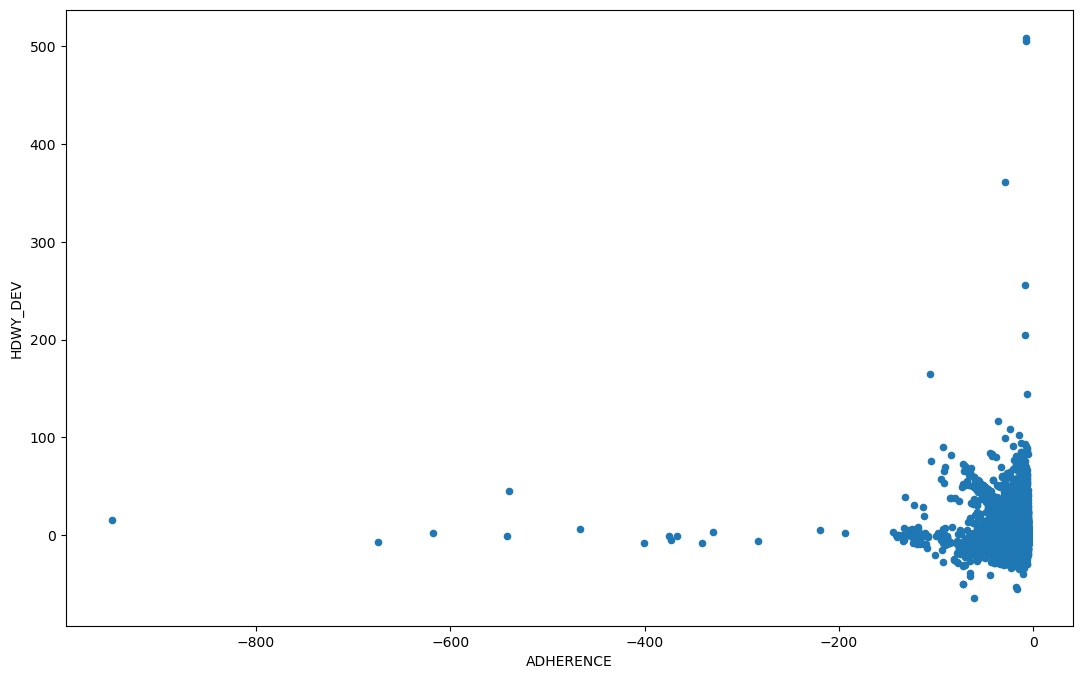

In [54]:
wego_late[['ADHERENCE', 'HDWY_DEV']].plot(x= 'ADHERENCE', y='HDWY_DEV',kind = 'scatter', figsize=(13,8))

<Axes: xlabel='ADHERENCE', ylabel='HDWY_DEV'>

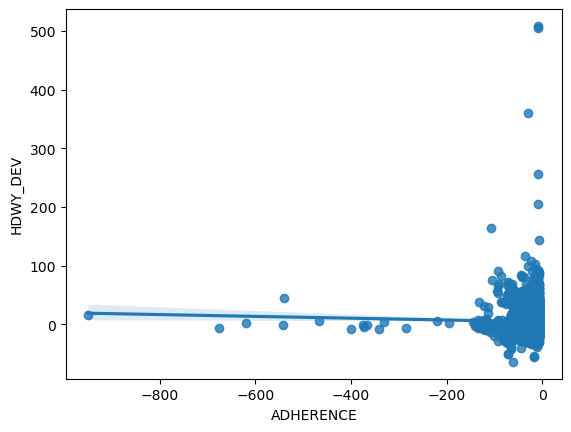

In [55]:
sns.regplot(x=wego_late['ADHERENCE'], y=wego_late['HDWY_DEV'])

Text(0, 0.5, 'Headway Deviation')

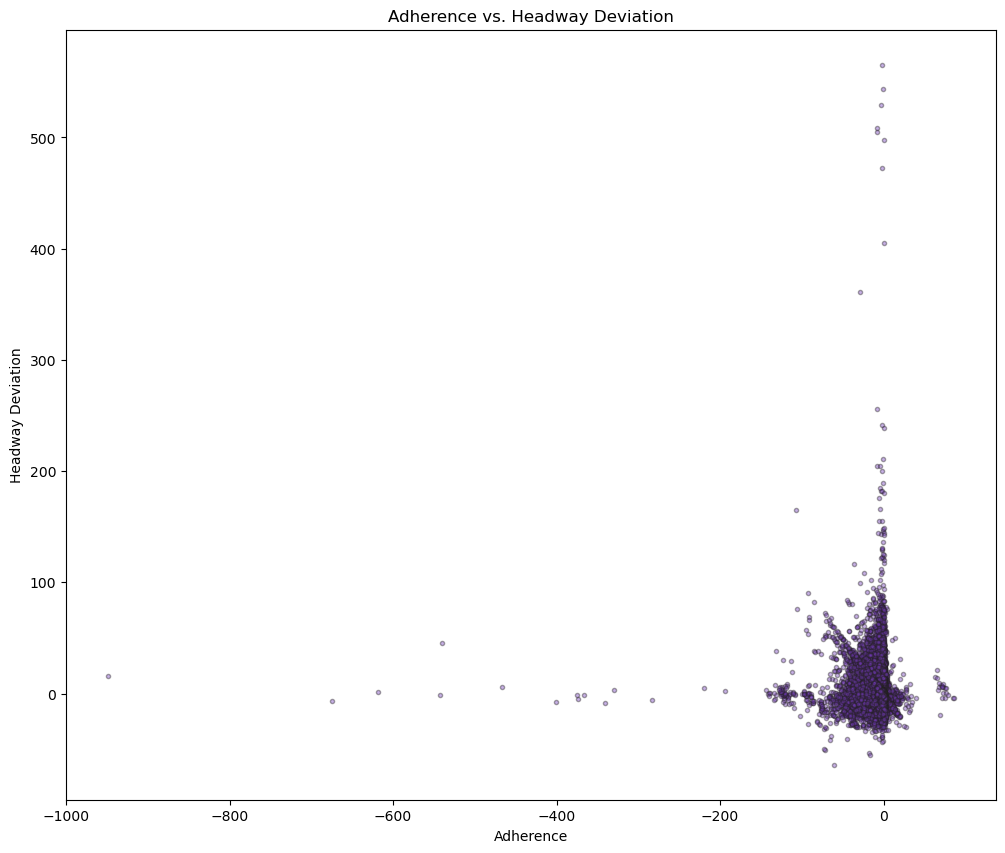

In [56]:
# PLOT Adherence vs Headway Deviation
plt.figure(figsize=(12,10))
plt.scatter(wego['ADHERENCE'],
            wego['HDWY_DEV'],
           color=[purple],
           edgecolor=[black],
           marker='.',
           alpha=0.4)

plt.title('Adherence vs. Headway Deviation')
plt.xlabel('Adherence')
plt.ylabel('Headway Deviation')

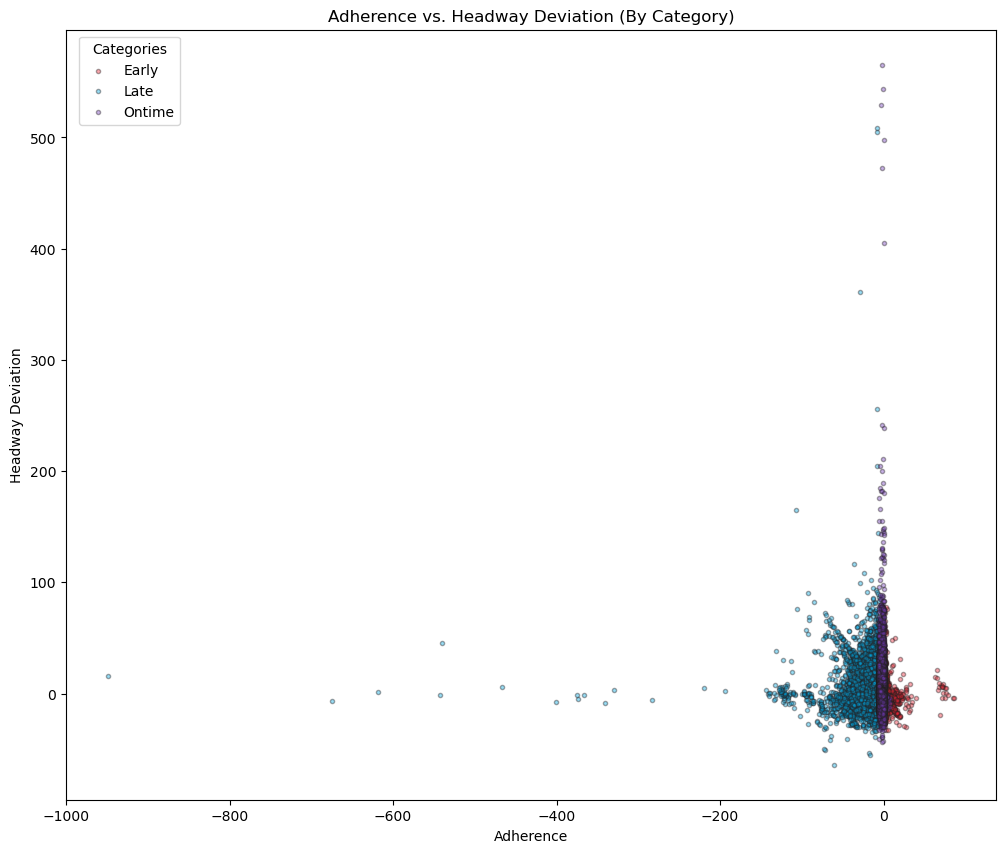

In [57]:
plt.figure(figsize=(12,10))
# creat fig
# fig = plt.figure()
# ax = fig.add_subplot(111)

#early
plt.scatter(wego.loc[wego['ADJUSTED_EARLY_COUNT']==1]['ADHERENCE'],
            wego.loc[wego['ADJUSTED_EARLY_COUNT']==1]['HDWY_DEV'],
           color=[red],
           edgecolor=[black],
           marker='.',
           alpha=0.4)

#late
plt.scatter(wego.loc[wego['ADJUSTED_LATE_COUNT']==1]['ADHERENCE'],
            wego.loc[wego['ADJUSTED_LATE_COUNT']==1]['HDWY_DEV'],
           color=[blue],
           edgecolor=[black],
           marker='.',
           alpha=0.4)

#ontime
plt.scatter(wego.loc[wego['ADJUSTED_ONTIME_COUNT']==1]['ADHERENCE'],
            wego.loc[wego['ADJUSTED_ONTIME_COUNT']==1]['HDWY_DEV'],
           color=[purple],
           edgecolor=[black],
           marker='.',
           alpha=0.4)



plt.title('Adherence vs. Headway Deviation (By Category)')
plt.xlabel('Adherence')
plt.ylabel('Headway Deviation')
plt.legend(bbox_to_anchor=(0.13,1), title='Categories', labels = ['Early','Late','Ontime'])

In [58]:
wego[['ADHERENCE','HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.206794
HDWY_DEV,-0.206794,1.000000


In [59]:
wego.loc[wego['ADJUSTED_ONTIME_COUNT']== 1][['ADHERENCE','HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.225793
HDWY_DEV,-0.225793,1.000000


In [60]:
wego.loc[wego['ADJUSTED_EARLY_COUNT']== 1][['ADHERENCE','HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.030098
HDWY_DEV,-0.030098,1.000000


In [61]:
wego.loc[wego['ADJUSTED_LATE_COUNT']== 1][['ADHERENCE','HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.018835
HDWY_DEV,-0.018835,1.000000
